In [20]:
#Modules import

import random
import math
import statistics
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import queue

In [21]:
# Class of colors to use with the print funtion
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [22]:
#Class that represents a sample

class Sample:
    def __init__(self, identifier, features):
        self.identifier = identifier #Number that identifies the sample
        self.features = features #Array of feature values of the sample
        self.cluster = None
        self.silhouette_a = None
        self.silhouette_b = None
        self.silhouette_score = None

In [23]:
#Class that represents a centroid

class Centroid:
    def __init__(self, identifier, features):
        self.identifier = identifier #Number that identifies the centroid
        self.features = features #Array of feature values of the centroid
        self.list_of_samples = [] #Array containing all the samples that are assigned to this centroid

In [24]:
#Class that represents a cluster
class Cluster:
    def __init__(self, identifier, list_of_samples):
        self.identifier = identifier #Number that identifies the cluster
        self.list_of_samples = list_of_samples #Array containing all the samples that are assigned to this cluster

In [25]:
#Function that applies the z-score method of normalization and standardization

def z_score_normalization(dataset, n_dimensions):
    for i in range(n_dimensions): #For each dimension i
        feature_values = [] #Create a list of all feature values of the i-th dimension
        for sample in dataset: #Fill the list
            feature_values.append(sample.features[i])
        feature_average = statistics.mean(feature_values) #Get the average value
        feature_stdev = statistics.stdev(feature_values) #Get the standard deviation value
        for sample in dataset: #For each sample, adjust its feature value of the i-th dimension
            sample.features[i] = (sample.features[i] - feature_average)/(feature_stdev) 

In [26]:
#Function that applies the min-max method of normalization

def min_max_normalization(dataset, n_dimensions):
    for i in range(n_dimensions): #For each dimension i
        max_value = -math.inf #Maximum value between the feature values of the i-th dimension
        min_value = math.inf #Minimum value between the feature values of the i-th dimension
        for sample in dataset: #Calculate max_value and min_value
            if sample.features[i] > max_value:
                max_value = sample.features[i]
            if sample.features[i] < min_value:
                min_value = sample.features[i]
        for sample in dataset: #For each sample, adjust its feature value of the i-th dimension
            sample.features[i] = (sample.features[i] - min_value)/(max_value - min_value)

In [27]:
#Read the dataset from input file

def get_dataset(filename):

    dataset_file = open(filename,"r") #Get the input file
    dataset_file_lines = dataset_file.readlines() #Read all the lines of the input file
    dataset = [] #Array that will contain all samples objects
    
    for i in range(len(dataset_file_lines)): #For each line of the input file
        dataset_file_lines[i] = dataset_file_lines[i].split() #Split the line at the spaces
        features = list(map(float, dataset_file_lines[i])) #Get the features values list in float format
        new_sample = Sample(i+1, features) #Create new Sample object
        dataset.append(new_sample) #Append the new sample to the dataset
        
    return dataset

In [28]:
#Divide the dataset into training and test sets

def divide_dataset(dataset, training_set_proportion, test_set_proportion):

    training_set_size = math.floor(training_set_proportion*len(dataset)) #Get the size of the training set
    #test_set_size = math.ceil(test_set_proportion*len(dataset)) #Get the size of the test set
    training_set = [] #Traning set array
    test_set = [] #Test set array

    for i in range(len(dataset)): #Partition the dataset into traning and test sets
        if i < training_set_size:
            training_set.append(dataset[i])
        else:
            test_set.append(dataset[i])
    return training_set, test_set

In [29]:
#Function that calculates the euclidean distance between two samples

def get_distance(sample1, sample2, n_dimensions):
    sum = 0
    for i in range(n_dimensions):
        sum = sum + (sample1.features[i] - sample2.features[i])**2
    return math.sqrt(sum)

In [30]:
#Function that plots the elbow graph with repetitions for a each value of k

def plot_elbow_graph(dataset, n_dimensions, min_k, max_k, n_repetitions):
    
    elbow_points = [] #Points of the elbow graph
    for k in range (min_k, max_k + 1): #For each value of k between min_k and max_k
        average = 0 #Variable that will contain the SSE average value 
        for j in range(n_repetitions): #Execute k-means n_repetitions times with same value of k
            clusters, centroids, sse = kmeans(dataset, k, n_dimensions) #Run the k-means algorithm
            average += sse
        average = float(average)/n_repetitions 
        elbow_points.append([k,average]) #Add the point (k, SSE average value)

    #Plot the graph
    x = []
    y = []
    for point in elbow_points:
        x.append(point[0])
        y.append(point[1])

    plt.xlabel("K", fontsize=15)
    plt.ylabel("SSE", fontsize=15)
    plt.xticks(list(range(min_k,max_k + 1)))    
    plt.grid(linestyle='--')
    plt.plot(x,y,'o-')
    plt.show()
    plt.close()

In [31]:
#Fuction that calculates the silhouette score of a clusterization

def calculate_silhouette_score(clusters, n_dimensions):
    
    #This loop calculates the "a-score" of each sample
    for cluster in clusters:    #For each cluster C
        for sample in cluster.list_of_samples: #For each sample s in C
            sample.silhouette_a = 0 #Attribute that contains the "a-score" of s
            for sample_in_same_cluster in cluster.list_of_samples: #For each sample s' in C
                if(not(sample.identifier == sample_in_same_cluster.identifier)): #If s != s'
                    sample.silhouette_a += get_distance(sample, sample_in_same_cluster, n_dimensions) #Get the distance between s and s'
            if(len(cluster.list_of_samples) > 1): #If |C| > 1, then calculates the "a-score" of s
                sample.silhouette_a = float(sample.silhouette_a)/(len(cluster.list_of_samples)-1)
    
    #This loop calculates the "b-score" of each sample    
    for cluster in clusters: #For each cluster C
        for sample in cluster.list_of_samples: #For each sample s in C
            min_b = math.inf #Variable that contains the minimum possible "b-score" of s
            for other_cluster in clusters: #For each cluster C'
                if(not(other_cluster.identifier == cluster.identifier)): #If C != C'
                    current_b = 0 #Variable that contains "b-score" of s for C'
                    for sample_in_other_cluster in other_cluster.list_of_samples: #For each sample s' in C'
                        current_b += get_distance(sample, sample_in_other_cluster, n_dimensions) #Get the distance between s and s'
                    current_b = float(current_b)/len(other_cluster.list_of_samples) #Calculates the "b-score" of s related to C'
                    min_b = min(min_b, current_b) #Update the min_b, if it is the case
            sample.silhouette_b = min_b #Attribute that contains the "b-score" of s
            
    silhouette_sample_scores = [] #Array that will contain the score of each sample
    for cluster in clusters: #For each cluster C
        for sample in cluster.list_of_samples: #For each sample s in C
            sample.silhouette_score = (sample.silhouette_b - sample.silhouette_a)/max(sample.silhouette_a,sample.silhouette_b) #Calculates the score of s
            silhouette_sample_scores.append(sample.silhouette_score) #Add the score of s to the array of scores

    silhouette_score = statistics.mean(silhouette_sample_scores) #Calculate the final score of the clusterization, that is the average of all sample scores
    
    return silhouette_score

In [32]:
#Function that plots the average silhouette score for a fixed k, for each k in a given range

def plot_silhouette_avg_score_graph(dataset, n_dimensions, min_k, max_k, n_repetitions):
    
    points = [] #Points of the graph
    for k in range(min_k, max_k + 1): #For each value of k between min_k and max_k
        average = 0 #Variable that will contain the silhouette average value for the fixed k
        for i in range(n_repetitions): #Execute k-means n_repetitions times with same value of k
            clusters, centroids, sse = kmeans(dataset, k, n_dimensions) #Run the k-means algorithm
            silhouette_score = calculate_silhouette_score(clusters, n_dimensions) #Get the silhouette score of the clusterization
            average += silhouette_score
        average = float(average)/n_repetitions #Calculates the average score
        points.append([k,average]) #Add the point (k, silhouette average value)
    
    #Plot the graph
    x = []
    y = []
    for point in points:
        x.append(point[0])
        y.append(point[1])

    plt.xlabel("K", fontsize=15)
    plt.ylabel("Silhouette average score", fontsize=15)
    plt.xticks(list(range(min_k,max_k + 1)))    
    plt.grid(linestyle='--')
    plt.plot(x,y,'o-', color='green')
    plt.show()
    plt.close()

In [33]:
#Function that plots the silhouette graph of a given clusterization

def plot_silhouette_graph(dataset, clusters, n_dimensions, k):
    
    #Calculate the silhouete score
    silhouette_score = calculate_silhouette_score(clusters, n_dimensions)
    
    #The following code plots the silhouette graph and it was adapted from 
    #https://medium.com/neuronio/unsupervised-learning-with-k-means-3eaa0666eebf
    
    silhouette_sample_scores = [] #Array that will contain the score of each sample
    for sample in dataset:
        silhouette_sample_scores.append(sample.silhouette_score) #Add the score of s to the array of scores
    min_silhouette_value = min(-0.1,min(silhouette_sample_scores))
    fig, (ax1) = plt.subplots(1)
    # The 1st subplot is the silhouette plot
    ax1.set_xlim([min_silhouette_value, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dataset) + (k + 1) * 10])
    # Compute the silhouette scores for each sample
    y_lower = 10
    for i,cluster in enumerate(clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = []
        for sample in cluster.list_of_samples:
            ith_cluster_silhouette_values.append(sample.silhouette_score)
        ith_cluster_silhouette_values.sort()
        size_cluster_i = len(ith_cluster_silhouette_values)
        y_upper = y_lower + size_cluster_i
        #color = plt.cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_score, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    x_ticks = []
    j = 1
    while j > min_silhouette_value:
        x_ticks.append(j)
        j = j - 0.1
    x_ticks.append(min_silhouette_value)
    ax1.set_xticks(x_ticks)
    print("Silhouette score for k = " + str(k) + ": " + str(silhouette_score))
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with " + str(k) + " clusters"))
    plt.show()
    plt.close()

In [34]:
#Function that plots a 2D graph of a clusterization

def plot_2D_clusters(clusters, centroids):
    for cluster in clusters:
        x = []
        y = []
        for sample in cluster.list_of_samples:
            x.append(sample.features[0])
            y.append(sample.features[1])
        plt.scatter(x, y)    
    x = []
    y = []
    for centroid in centroids: #If the centroids of the k-means were given in the input, plot them too
        x.append(centroid.features[0])
        y.append(centroid.features[1])
    plt.scatter(x, y, marker="x", color="black")
    plt.grid(linestyle='--')
    plt.show()
    plt.close()

# K-Means method

In [35]:
##### K-means algorithm ######

#Function that assings each sample to a centroid

def set_clusters(dataset, centroids, dimensions):
    
    for centroid in centroids: #Initialize the list of samples of each centroid as an empty list
        centroid.list_of_samples = []
        
    for sample in dataset: #For each sample
        closest_centroid = None #Variable that will contain the closest centroid
        min_distance = math.inf
        for centroid in centroids: #Check the distance of all centroids and select the closest
            distance = get_distance(sample, centroid, dimensions)
            if distance < min_distance:
                min_distance = distance
                closest_centroid = centroid
        closest_centroid.list_of_samples.append(sample) #Add the sample to the list of samples of the closest centroid

        
#Function that calculates the Sum of the Squared Error

def get_sse(centroids, dimensions):
    sum = 0
    for centroid in centroids:
        for sample in centroid.list_of_samples:
            sum = sum + get_distance(centroid, sample, dimensions)**2
    return sum

#Function that updates the features values of each centroid

def update_centroids(centroids):
    for centroid in centroids: #For each centroid
        for i in range(len(centroid.features)): #For each feature of the centroid
            centroid.features[i] = 0  
            for j in range(len(centroid.list_of_samples)): #Collected the feature value of each sample assigned to the centroid
                centroid.features[i] += centroid.list_of_samples[j].features[i]
            if(len(centroid.list_of_samples) > 0): #If the cluster is not empty
                centroid.features[i] = centroid.features[i]/float(len(centroid.list_of_samples)) #Apply the average value

#Function that implements the k-means clusterization method

def kmeans(dataset, n_clusters, dimensions):
    
    drawed_samples = random.sample(dataset, n_clusters) #Draw n_clusters samples to be the initial centroids
    centroids = [] #Array of centroids
    for i in range(n_clusters): #Add the initial centroids
        new_centroid = Centroid(i+1, drawed_samples[i].features.copy())
        centroids.append(new_centroid)
    
    set_clusters(dataset, centroids, dimensions) #Set the initial clusters
    current_sse = get_sse(centroids, dimensions) #Calculate the inital error value
    sse_converged = False #Flag that indicates if the error value converged
    
    iteration = 1
    #print("Iteration #" + str(iteration))
    #plot_2D_clusters(centroids)
    
    while(not sse_converged): #Main loop of kmeans
        update_centroids(centroids) #Update the centroid features values
        set_clusters(dataset, centroids, dimensions) #Reset the clusters
        new_sse = get_sse(centroids, dimensions) #Get the new error value
        if new_sse < current_sse: #Check if the error value converged
            current_sse = new_sse
        else:
            sse_converged = True
        iteration += 1
        #print("Iteration #" + str(iteration))
        #plot_2D_clusters(centroids)
        
    clusters = []
    i = 1
    for centroid in centroids:
        new_cluster = Cluster(i, centroid.list_of_samples.copy())
        clusters.append(new_cluster)
        for sample in new_cluster.list_of_samples:
            sample.cluster = new_cluster
        i += 1
    
    return clusters, centroids, current_sse

#Function that extends a clusterization made by k-means to cluster the points from the test set
def extend_kmeans_clusterization(centroids, test_set, n_dimensions):
    set_clusters(test_set, centroids, n_dimensions)
    clusters = []
    i = 1
    for centroid in centroids:
        new_cluster = Cluster(i, centroid.list_of_samples.copy())
        clusters.append(new_cluster)
        for sample in new_cluster.list_of_samples:
            sample.cluster = new_cluster
        i += 1
    return clusters

### Running K-means over two-dimensional dataset

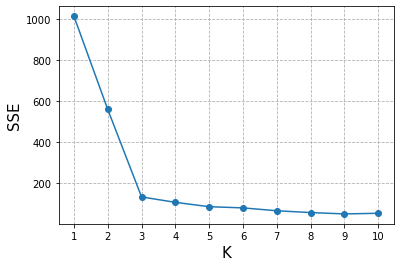

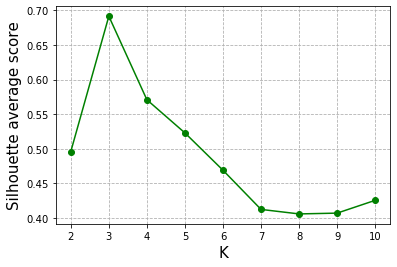

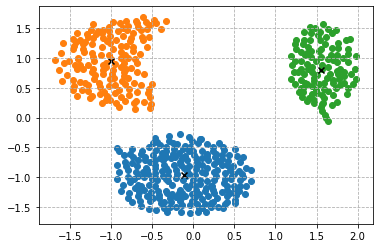

Silhouette score for k = 3: 0.6916289097903533


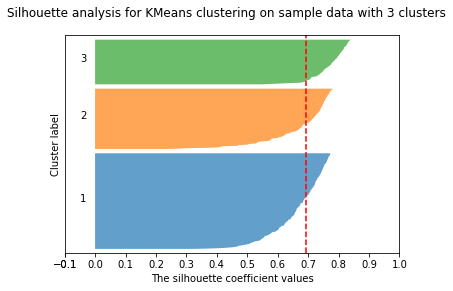

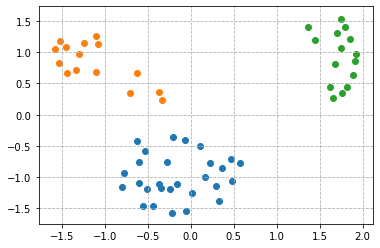

Silhouette score for k = 3: 0.6913289004455297


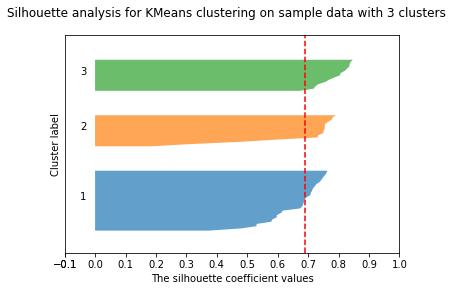

'\n#Testing K-means with 10-dimensional dataset\ndataset = get_dataset("trip_advisor.dat") #Build the dataset\nn_dimensions = 10\nrandom.shuffle(dataset) #Randomize the dataset array\n#min_max_normalization(dataset, n_dimensions) #Apply the min-max normalization\nz_score_normalization(dataset, n_dimensions) #Apply the z-score normalization\ntraining_set, test_set = divide_dataset(dataset, 0.9, 0.1) #Partition the dataset into training set and test set\nplot_elbow_graph(training_set, n_dimensions,1, 10, 5) #Plot elbow graph\nplot_silhouette_avg_score_graph(training_set,n_dimensions, 2, 10, 5) #Plot silhouette average score graph\n\nfor k in [2]:\n    clusters, centroids, sse = kmeans(training_set, k, n_dimensions)\n    plot_silhouette_graph(training_set, clusters, n_dimensions, k)\n    clusters_test_set = extend_kmeans_clusterization(centroids, test_set, n_dimensions)\n    plot_silhouette_graph(test_set, clusters_test_set, n_dimensions, k)\n'

In [36]:
#Experiment Part 1


#Testing K-means with 2-dimensional dataset

dataset = get_dataset("cluster.dat") #Build the dataset
n_dimensions = 2 #Set the number of dimensions
random.shuffle(dataset) #Randomize the dataset array
#min_max_normalization(dataset, n_dimensions) #Apply the min-max normalization
z_score_normalization(dataset, n_dimensions) #Apply the z-score normalization
training_set, test_set = divide_dataset(dataset, 0.9, 0.1) #Partition the dataset into training set and test set

plot_elbow_graph(training_set, n_dimensions,1, 10, 5) #Plot elbow graph
plot_silhouette_avg_score_graph(training_set,n_dimensions, 2, 10, 5) #Plot silhouette average score graph

for k in [3]:
    clusters, centroids, sse = kmeans(training_set, k, n_dimensions)
    plot_2D_clusters(clusters, centroids)
    plot_silhouette_graph(training_set, clusters, n_dimensions, k)
    clusters_test_set = extend_kmeans_clusterization(centroids, test_set, n_dimensions)
    plot_2D_clusters(clusters_test_set, [])
    plot_silhouette_graph(test_set, clusters_test_set, n_dimensions, k)

"""
#Testing K-means with 10-dimensional dataset
dataset = get_dataset("trip_advisor.dat") #Build the dataset
n_dimensions = 10
random.shuffle(dataset) #Randomize the dataset array
#min_max_normalization(dataset, n_dimensions) #Apply the min-max normalization
z_score_normalization(dataset, n_dimensions) #Apply the z-score normalization
training_set, test_set = divide_dataset(dataset, 0.9, 0.1) #Partition the dataset into training set and test set
plot_elbow_graph(training_set, n_dimensions,1, 10, 5) #Plot elbow graph
plot_silhouette_avg_score_graph(training_set,n_dimensions, 2, 10, 5) #Plot silhouette average score graph

for k in [2]:
    clusters, centroids, sse = kmeans(training_set, k, n_dimensions)
    plot_silhouette_graph(training_set, clusters, n_dimensions, k)
    clusters_test_set = extend_kmeans_clusterization(centroids, test_set, n_dimensions)
    plot_silhouette_graph(test_set, clusters_test_set, n_dimensions, k)
"""

# DBSCAN method

In [ ]:
#Class that represents a node for the DBSCAN method
class DBSCAN_node:
    def __init__(self, sample, label, cluster):
        self.sample = sample 
        self.label = label   # (undefined | noise | core | border)
        self.cluster = cluster # name of the cluster the node belongs to
        self.neighborhood = set() 
        
def DBSCAN_initialization(dataset):
    DBSCAN_dataset = []
    for sample in dataset:
        new_node = DBSCAN_node(sample, "undefined", -1)
        DBSCAN_dataset.append(new_node)
    
    return DBSCAN_dataset

In [ ]:
def DBSCAN_plot_2D_clusters(clusters):
    for c in clusters:
        x = []
        y = []
        for point in clusters[c]:
            x.append(point.sample.features[0])
            y.append(point.sample.features[1])
        plt.scatter(x, y)    
    plt.show()

    
def DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, point):
    neighbors = []
    for n in dataset:
        if dist_func(n.sample, point.sample, dim) <= eps:
            neighbors.append(n)
    
    return set(neighbors)


def DBSCAN_find_cluster(dataset, dist_func, dim, eps, minPoints, core, n_cluster):
    cluster = []
    to_explore = deque()
    
    cluster.append(core)
    to_explore.append(core)
    
    # explore neighborhoods to expand the current cluster
    while len(to_explore) > 0:
        q = to_explore.popleft()
        q.neighborhood = DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, q)          
        
        # classify current point according to the size of its neighborhood
        if len(q.neighborhood) >= minPoints: # current point is core
            q.label = "core" 
            
            # mark each neighbor as part of the current cluster 
            for r in q.neighborhood:
                if r.label == "undefined" or r.label == "noise":
                    r.cluster = n_cluster
                    cluster.append(r)
                    
                    # classify current neighbor according to the size of its neighborhood
                    if len(DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, r)) >= minPoints:
                        r.label = "core"
                    else:
                        r.label = "border"
                    
                    # add neighbor to the queue (if it is not there yet), so its neioghborhood will be analyzed
                    if r not in to_explore:
                        to_explore.append(r)
                
        else: # current point is border  
            q.label = "border" 
    
    return cluster
    

# DBSCAN implementation
def DBSCAN(dataset, dist_func, dim, eps, minDensity):
    # obtain a dataset in the convenient format
    dataset = DBSCAN_initialization(dataset)
    
    # initialize auxiliary variables
    n_clusters = 0   # name of the clusters
    clusters = {}    # clusters obtained as the model
    clusters[0] = [] # list to gather all outliers in one cluster
    
    for point in dataset:
        if point.label == "undefined":
            point.neighborhood = DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, point)
            
            # check neighborhood of the current point
            if len(point.neighborhood) >= minDensity: # neighborhood is large enough, current point is a core point
                point.label = "core"
                
                # start a new cluster
                n_clusters += 1 
                point.cluster = n_clusters
                clusters[n_clusters] = DBSCAN_find_cluster(dataset, dist_func, dim, eps, minDensity, point, n_clusters)
            
            else: # neighborhood not large enough, then classify current point as noise so that it may later be joined in some cluster
                point.label = "noise"
                point.cluster = 0
                    
    # create one cluster for all the outliers
    for point in dataset:
        if point.label == "noise":
            clusters[0].append(point)

    return dataset, clusters              
    

In [80]:
def DBSCAN_get_nearest_distances(dataset, dist_func, dim, k, point):
    dist = []
    for q in dataset:
        dist.append(get_distance(q, point, dim))
    
    return sorted(dist)[:k]

# plot an elbow graph based on the k-nearest neighbors graph
def DBSCAN_plot_elbow_graph(dataset, func_dist, dim, k):

    k_neighbors = {p : [] for p in dataset}
    for p in dataset:
        k_neighbors[p] = DBSCAN_get_nearest_distances(dataset, func_dist, dim, k, p) 

    estimated_eps = [k_neighbors[p][k-1:] for p in training_set]
    estimated_eps = sorted(estimated_eps, reverse=True)

    # plot the elbow graph
    x = [i for i in range(len(estimated_eps))]
    y = estimated_eps
    plt.xlabel("index")
    plt.ylabel("distance")
    plt.plot(x, y, 'g-')    
    plt.show()


# Plot the Silhouette coefficient for a set of clusters (model)
def DBSCAN_plot_silhouette_graph(dataset, clusters, dim, eps):
    clusters_list = []
    c_pairs = clusters.items()
    for p in c_pairs:
        sample_list = []
        for q in p[1]:
            sample_list.append(q.sample)

        clusters_list.append( Cluster(p[0], sample_list) )

    if len(clusters_list[0].list_of_samples) <= 0:
        clusters_list = clusters_list[1:]

    plot_silhouette_graph(dataset, clusters_list, dim, eps)


# Run DBSCAN over the dataset using different values of minimum density and distance
def DBSCAN_plot_multiple_parameters(dataset, minDensity, maxDensity, step, func_dist, dim, plot=True):
    for density in range(minDensity, maxDensity+1, step):
        
        print(color.BOLD)
        print("-------------------------------------------------------------------------------------")
        print("Elbow graph with k = ", density)
        print(color.END)
        DBSCAN_plot_elbow_graph(dataset, func_dist, dim, density)
        
        for eps in range(density, 0, -1):
            model = []
            clusters = {}
            model, clusters = DBSCAN(dataset, func_dist, dim, eps/density, density)
            print("---------------------------------------------------------------------------------")
            print("\033[1mConfiguration:\033[0m minDensity = ", density, ", eps = ", eps/density)
            print("There are", len(clusters)-1, "clusters and", len(clusters[0]), "outliers.")
            if len(clusters[0]) <= 0:
                del clusters[0]
            
            if (plot): 
                DBSCAN_plot_2D_clusters(clusters)
                
            DBSCAN_plot_silhouette_graph(training_set, clusters, 2, eps/density)


## Running DBSCAN for a two-dimensional dataset

In [81]:
# Get dataset
ds_filepath = "cluster.dat"
ds = get_dataset(ds_filepath)

# Pre-process and divide the dataset into training and test sets
random.seed(37154) 
random.shuffle(ds) 
training_set, test_set = divide_dataset(ds, 0.9, 0.1)
z_score_normalization(training_set, 2)
z_score_normalization(test_set, 2)

### Tunning the hiper-parameters

As a rule of thumb, we have chosen the minimum density to vary from to be 2 times the dimension of the dataset up to 20. As for the minimum distance, we used the k-nearest neighbor graph to plotted the largest distance among the k nearest neighbors of each sample.
In the following, we ran our DBSCAN implementation over the training set, varying the values of minimum density and minimum distance. For each differente pais of hiper-parameters, we plot the clusters obtained and the corresponding silhouette graph.


-------------------------------------------------------------------------------------
Elbow graph with k =  4



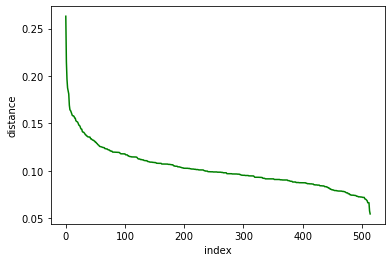

---------------------------------------------------------------------------------
Configuration: minDensity =  4 , eps =  1.0
There are 2 clusters and 0 outliers.


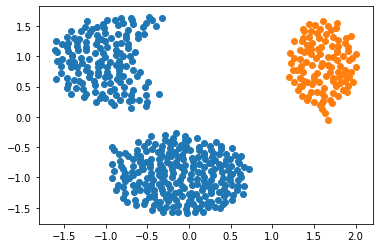

Silhouette score for k = 1.0: 0.5330628256927767


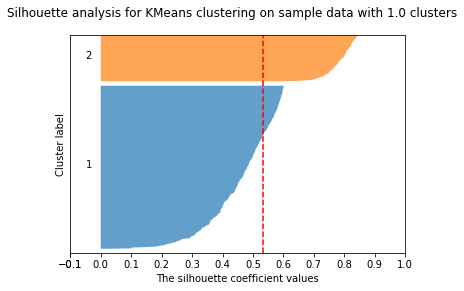

---------------------------------------------------------------------------------
Configuration: minDensity =  4 , eps =  0.75
There are 2 clusters and 0 outliers.


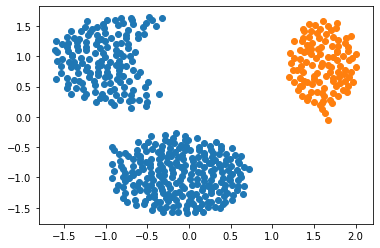

Silhouette score for k = 0.75: 0.5330628256927767


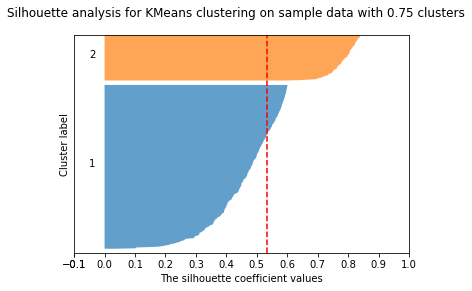

---------------------------------------------------------------------------------
Configuration: minDensity =  4 , eps =  0.5
There are 3 clusters and 0 outliers.


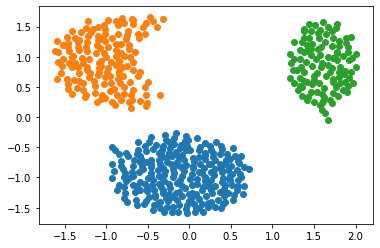

Silhouette score for k = 0.5: 0.6931958759464847


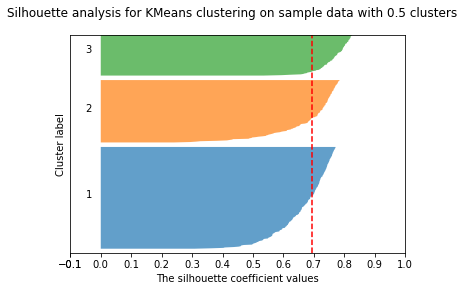

---------------------------------------------------------------------------------
Configuration: minDensity =  4 , eps =  0.25
There are 3 clusters and 0 outliers.


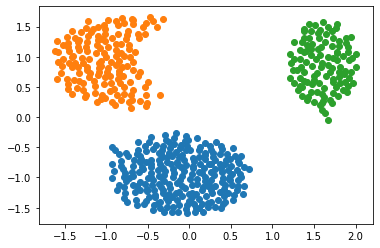

Silhouette score for k = 0.25: 0.6931958759464847


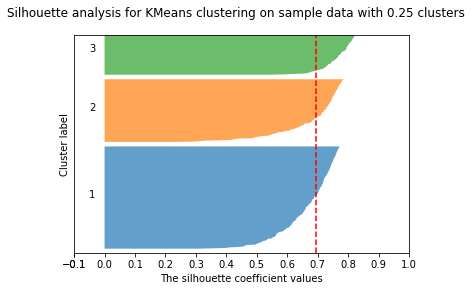


-------------------------------------------------------------------------------------
Elbow graph with k =  9



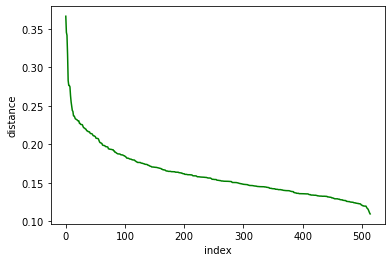

---------------------------------------------------------------------------------
Configuration: minDensity =  9 , eps =  1.0
There are 2 clusters and 0 outliers.


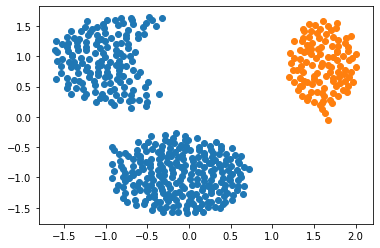

Silhouette score for k = 1.0: 0.5330628256927767


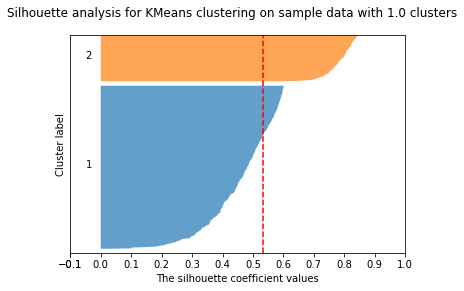

---------------------------------------------------------------------------------
Configuration: minDensity =  9 , eps =  0.8888888888888888
There are 2 clusters and 0 outliers.


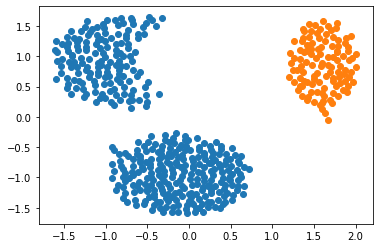

Silhouette score for k = 0.8888888888888888: 0.5330628256927767


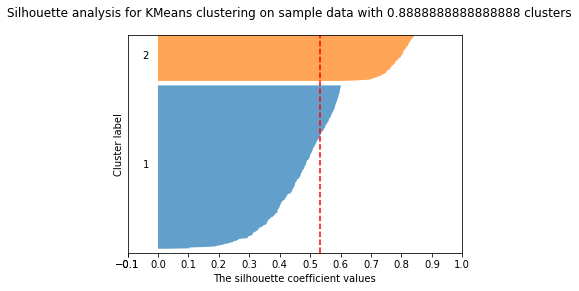

---------------------------------------------------------------------------------
Configuration: minDensity =  9 , eps =  0.7777777777777778
There are 2 clusters and 0 outliers.


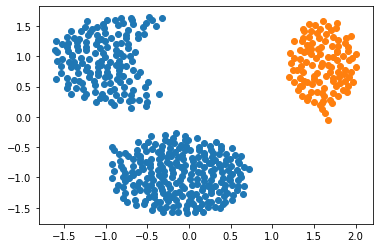

Silhouette score for k = 0.7777777777777778: 0.5330628256927767


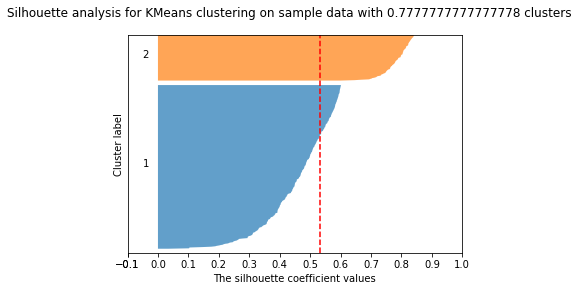

---------------------------------------------------------------------------------
Configuration: minDensity =  9 , eps =  0.6666666666666666
There are 2 clusters and 0 outliers.


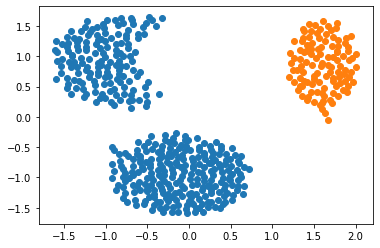

Silhouette score for k = 0.6666666666666666: 0.5330628256927767


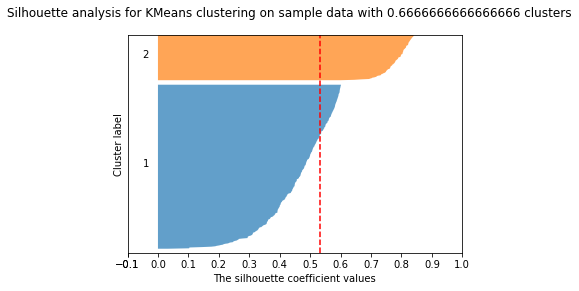

---------------------------------------------------------------------------------
Configuration: minDensity =  9 , eps =  0.5555555555555556
There are 2 clusters and 0 outliers.


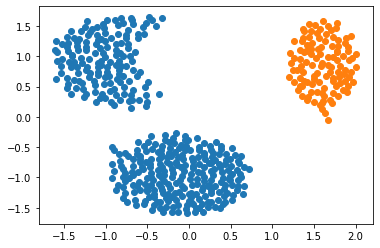

Silhouette score for k = 0.5555555555555556: 0.5330628256927767


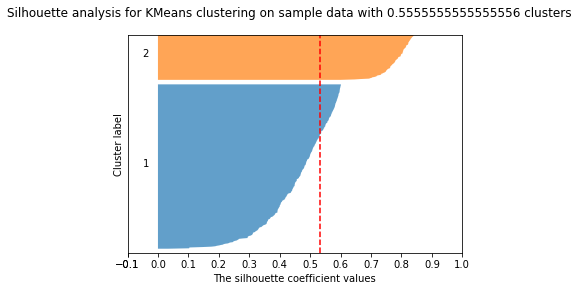

---------------------------------------------------------------------------------
Configuration: minDensity =  9 , eps =  0.4444444444444444
There are 3 clusters and 0 outliers.


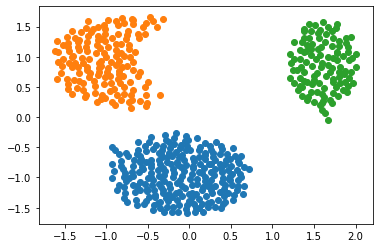

Silhouette score for k = 0.4444444444444444: 0.6931958759464847


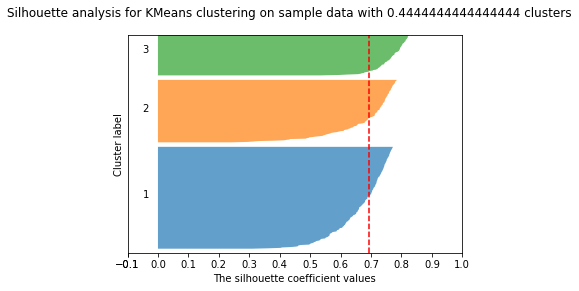

---------------------------------------------------------------------------------
Configuration: minDensity =  9 , eps =  0.3333333333333333
There are 3 clusters and 0 outliers.


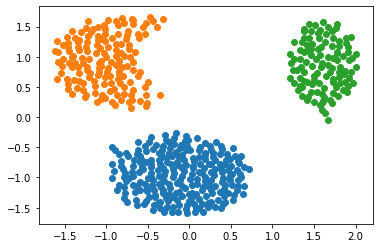

Silhouette score for k = 0.3333333333333333: 0.6931958759464847


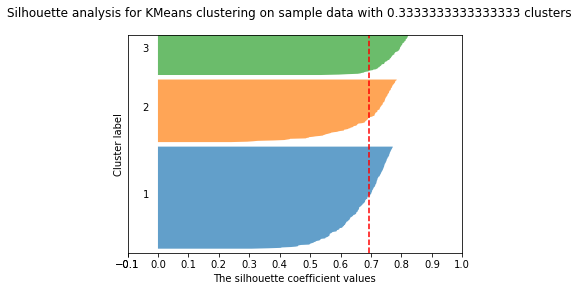

---------------------------------------------------------------------------------
Configuration: minDensity =  9 , eps =  0.2222222222222222
There are 3 clusters and 0 outliers.


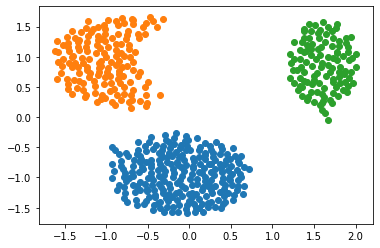

Silhouette score for k = 0.2222222222222222: 0.6931958759464847


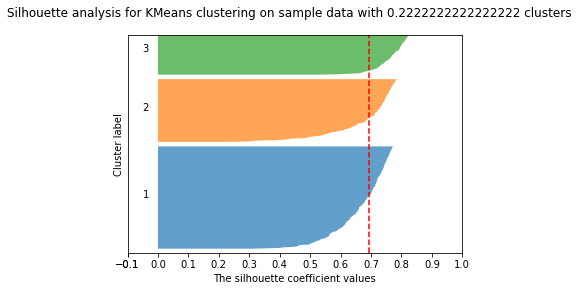

---------------------------------------------------------------------------------
Configuration: minDensity =  9 , eps =  0.1111111111111111
There are 2 clusters and 497 outliers.


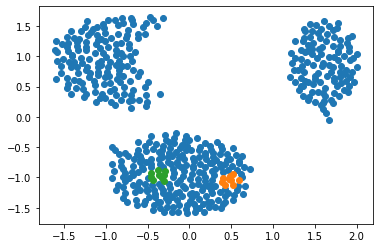

Silhouette score for k = 0.1111111111111111: -0.26540743553347645


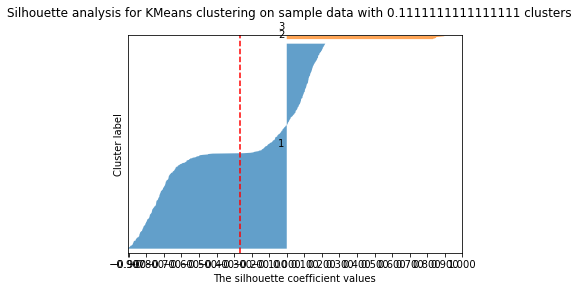


-------------------------------------------------------------------------------------
Elbow graph with k =  14



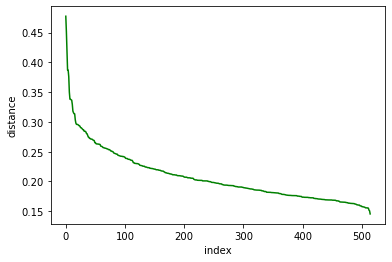

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  1.0
There are 2 clusters and 0 outliers.


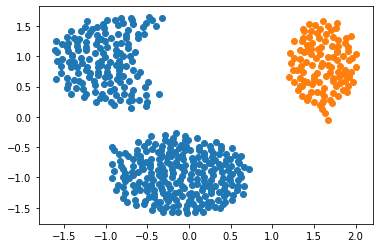

Silhouette score for k = 1.0: 0.5330628256927767


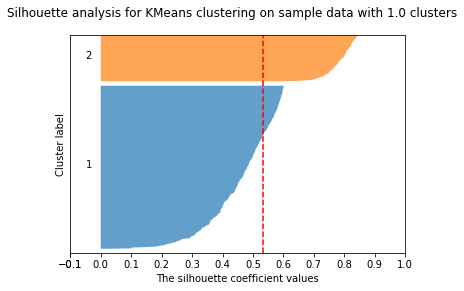

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  0.9285714285714286
There are 2 clusters and 0 outliers.


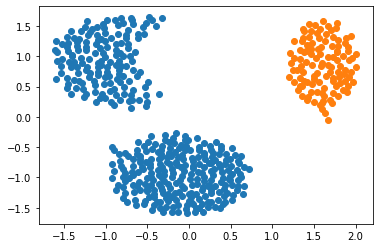

Silhouette score for k = 0.9285714285714286: 0.5330628256927767


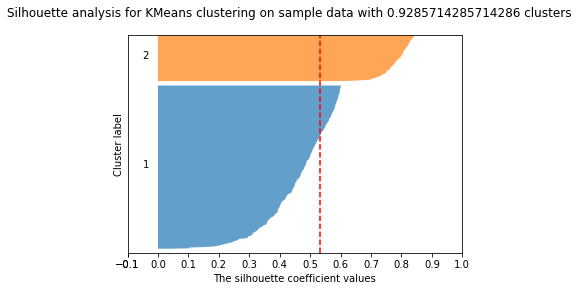

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  0.8571428571428571
There are 2 clusters and 0 outliers.


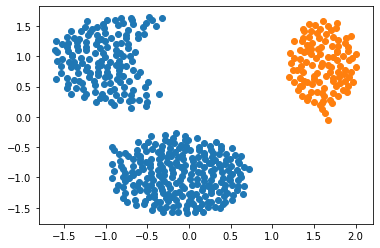

Silhouette score for k = 0.8571428571428571: 0.5330628256927767


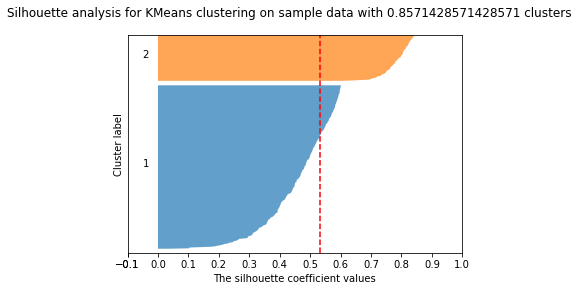

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  0.7857142857142857
There are 2 clusters and 0 outliers.


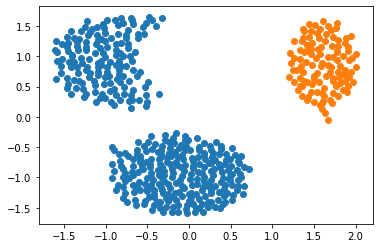

Silhouette score for k = 0.7857142857142857: 0.5330628256927767


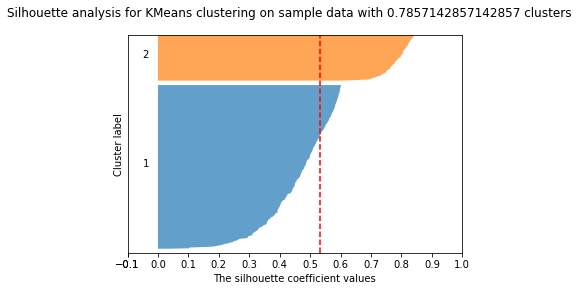

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  0.7142857142857143
There are 2 clusters and 0 outliers.


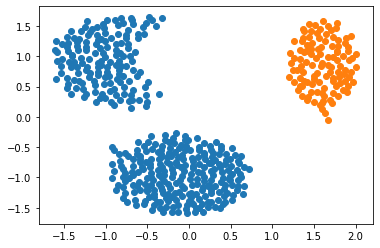

Silhouette score for k = 0.7142857142857143: 0.5330628256927766


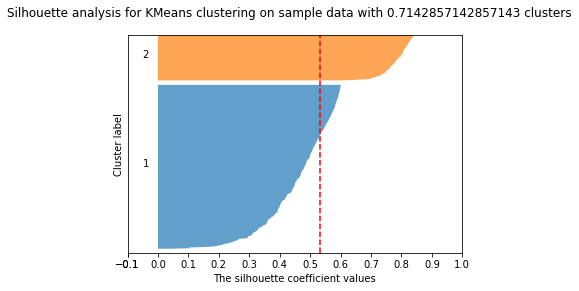

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  0.6428571428571429
There are 2 clusters and 0 outliers.


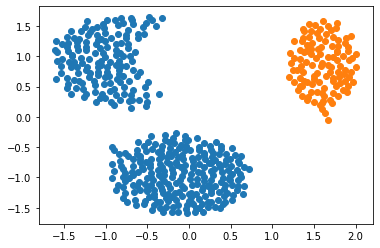

Silhouette score for k = 0.6428571428571429: 0.5330628256927767


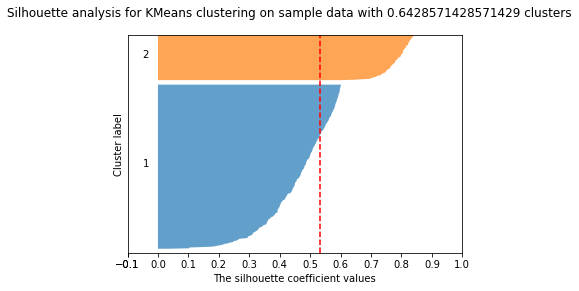

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  0.5714285714285714
There are 2 clusters and 0 outliers.


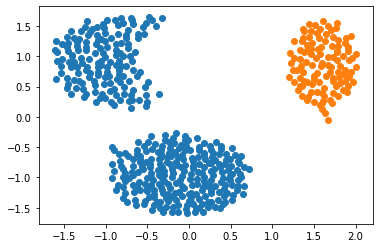

Silhouette score for k = 0.5714285714285714: 0.5330628256927767


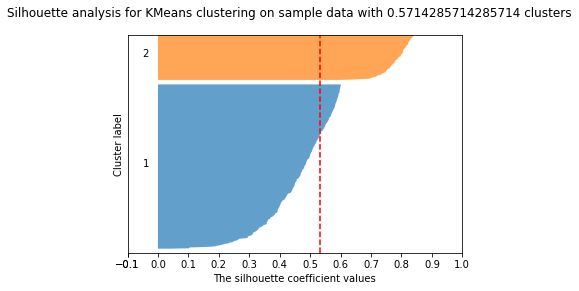

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  0.5
There are 3 clusters and 0 outliers.


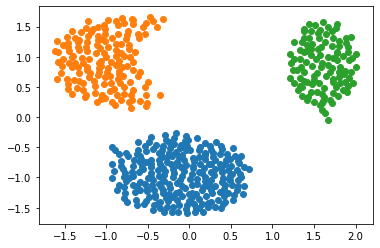

Silhouette score for k = 0.5: 0.6931958759464847


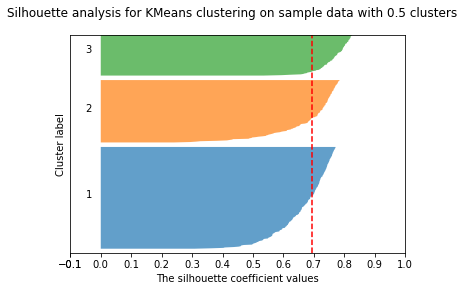

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  0.42857142857142855
There are 3 clusters and 0 outliers.


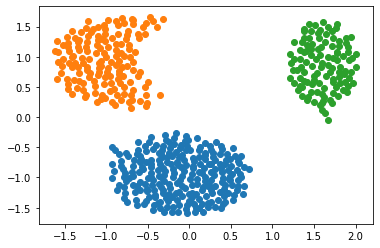

Silhouette score for k = 0.42857142857142855: 0.6931958759464847


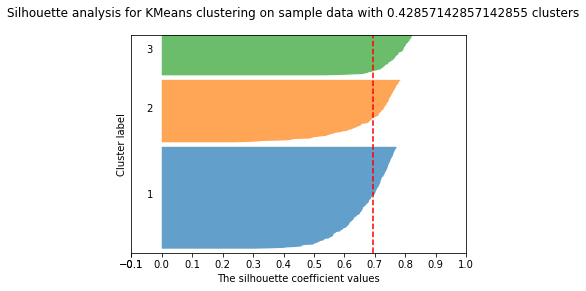

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  0.35714285714285715
There are 3 clusters and 0 outliers.


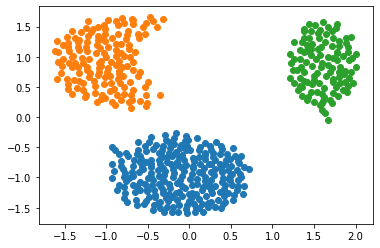

Silhouette score for k = 0.35714285714285715: 0.6931958759464847


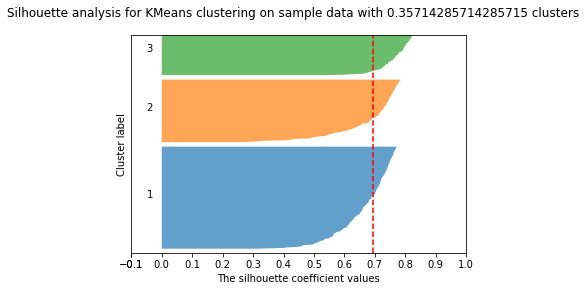

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  0.2857142857142857
There are 3 clusters and 0 outliers.


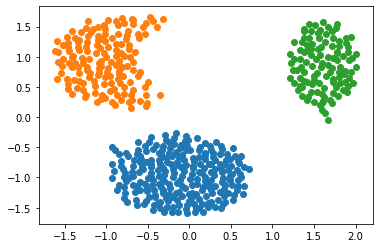

Silhouette score for k = 0.2857142857142857: 0.6931958759464847


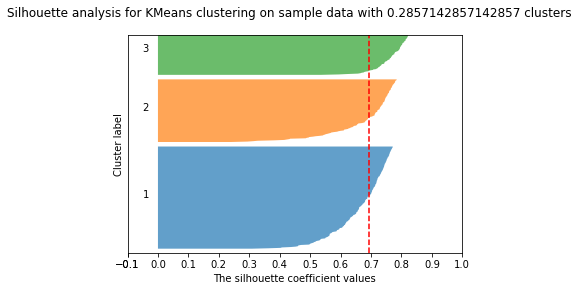

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  0.21428571428571427
There are 3 clusters and 22 outliers.


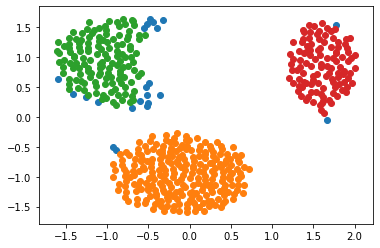

Silhouette score for k = 0.21428571428571427: 0.5772216029796103


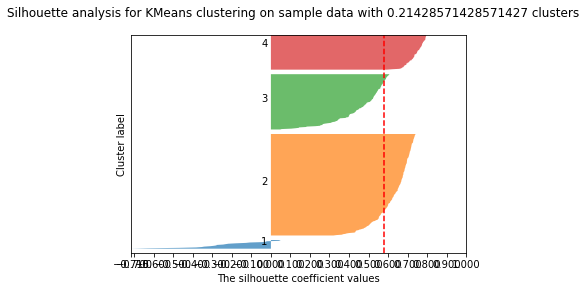

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  0.14285714285714285
There are 0 clusters and 515 outliers.


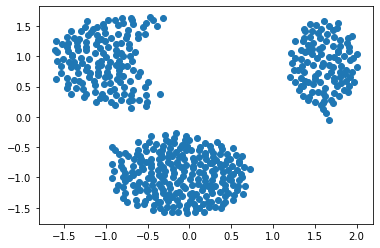

Silhouette score for k = 0.14285714285714285: nan


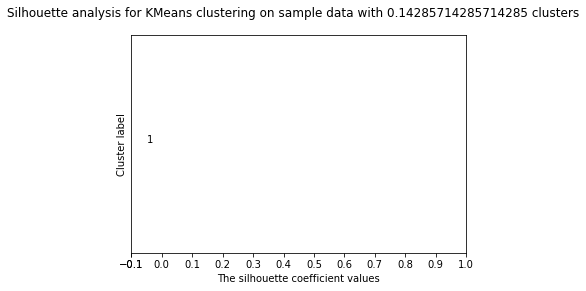

---------------------------------------------------------------------------------
Configuration: minDensity =  14 , eps =  0.07142857142857142
There are 0 clusters and 515 outliers.


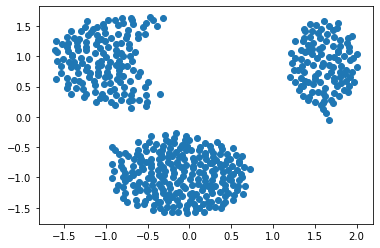

Silhouette score for k = 0.07142857142857142: nan


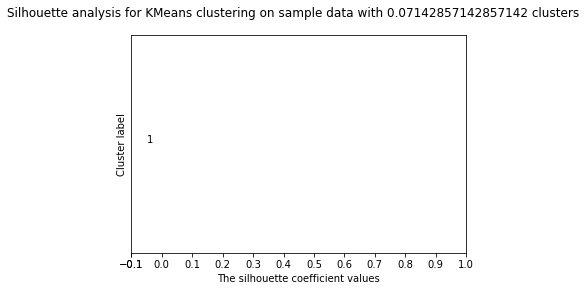


-------------------------------------------------------------------------------------
Elbow graph with k =  19



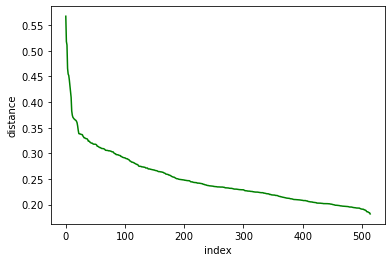

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  1.0
There are 2 clusters and 0 outliers.


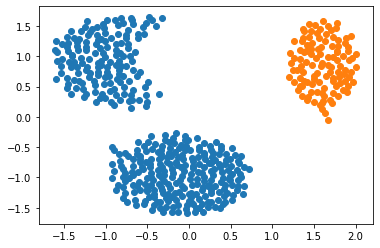

Silhouette score for k = 1.0: 0.5330628256927767


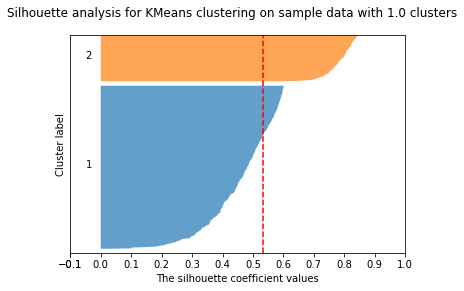

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.9473684210526315
There are 2 clusters and 0 outliers.


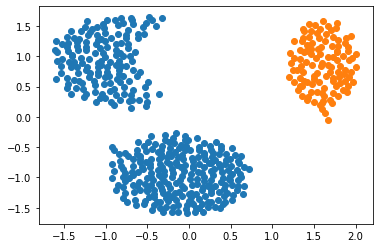

Silhouette score for k = 0.9473684210526315: 0.5330628256927767


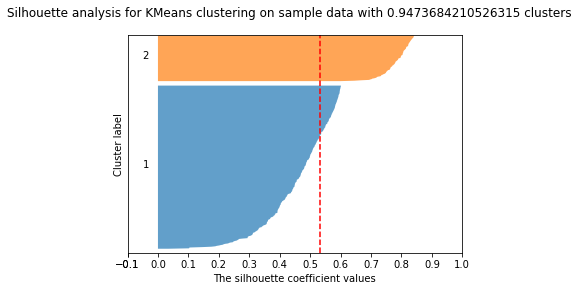

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.8947368421052632
There are 2 clusters and 0 outliers.


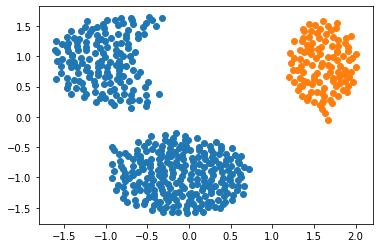

Silhouette score for k = 0.8947368421052632: 0.5330628256927767


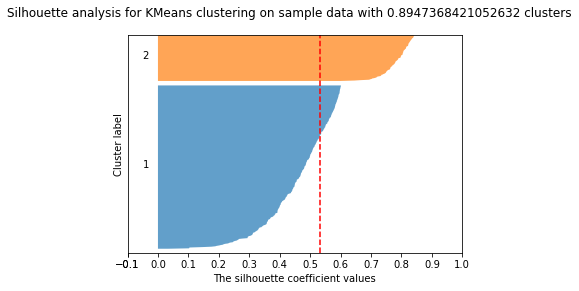

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.8421052631578947
There are 2 clusters and 0 outliers.


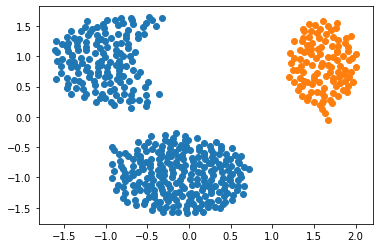

Silhouette score for k = 0.8421052631578947: 0.5330628256927767


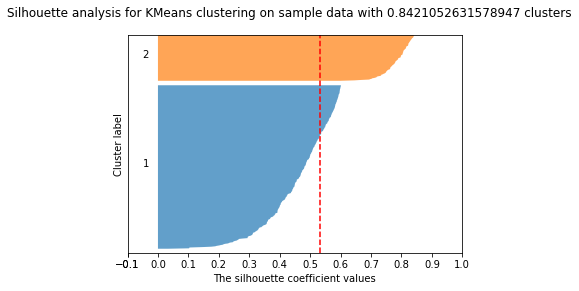

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.7894736842105263
There are 2 clusters and 0 outliers.


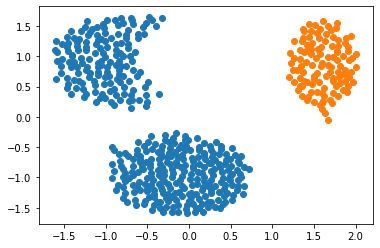

Silhouette score for k = 0.7894736842105263: 0.5330628256927767


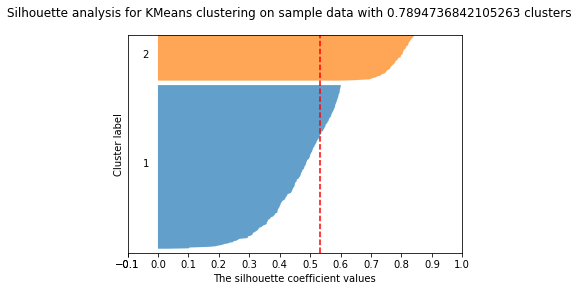

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.7368421052631579
There are 2 clusters and 0 outliers.


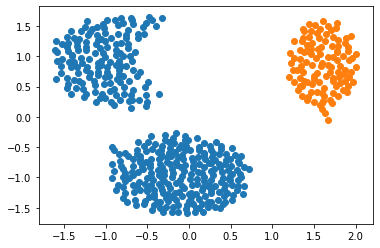

Silhouette score for k = 0.7368421052631579: 0.5330628256927767


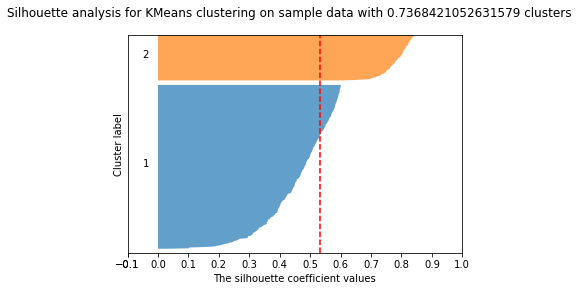

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.6842105263157895
There are 2 clusters and 0 outliers.


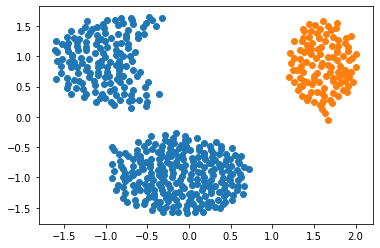

Silhouette score for k = 0.6842105263157895: 0.5330628256927767


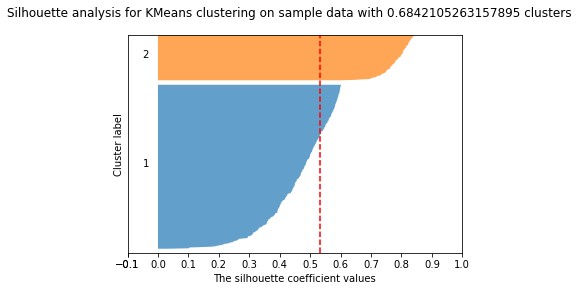

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.631578947368421
There are 2 clusters and 0 outliers.


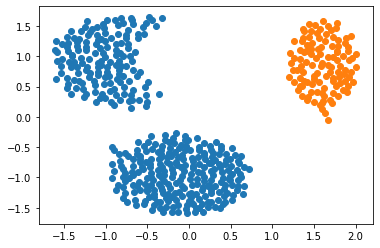

Silhouette score for k = 0.631578947368421: 0.5330628256927767


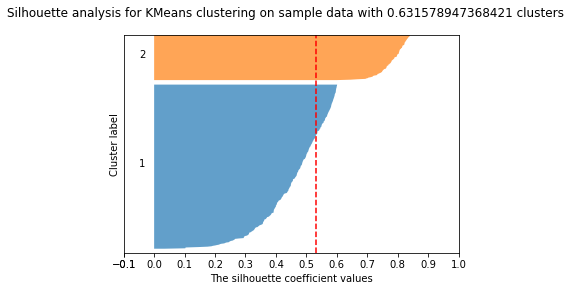

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.5789473684210527
There are 2 clusters and 0 outliers.


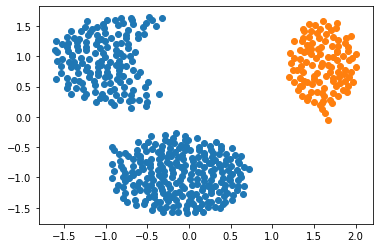

Silhouette score for k = 0.5789473684210527: 0.5330628256927767


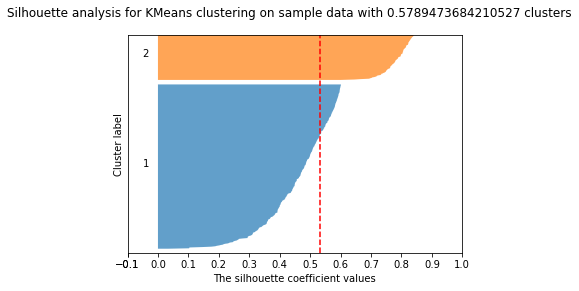

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.5263157894736842
There are 2 clusters and 0 outliers.


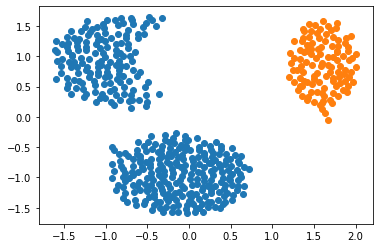

Silhouette score for k = 0.5263157894736842: 0.5330628256927767


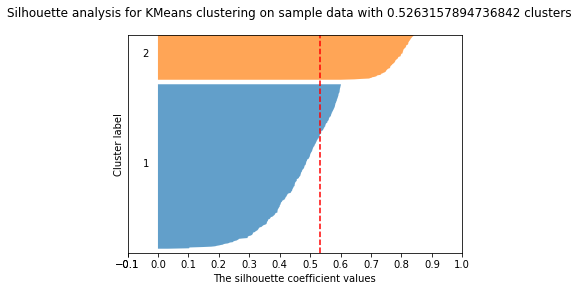

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.47368421052631576
There are 3 clusters and 0 outliers.


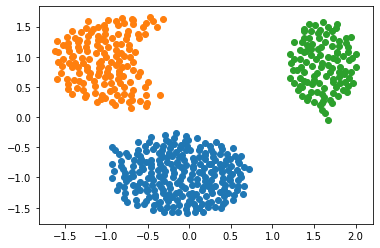

Silhouette score for k = 0.47368421052631576: 0.6931958759464847


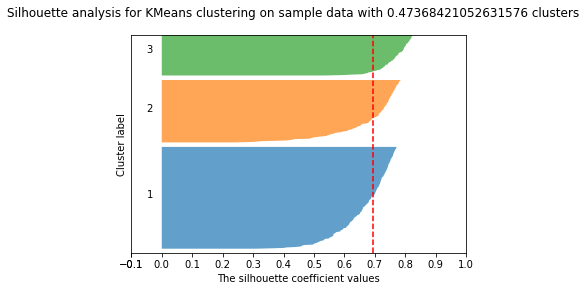

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.42105263157894735
There are 3 clusters and 0 outliers.


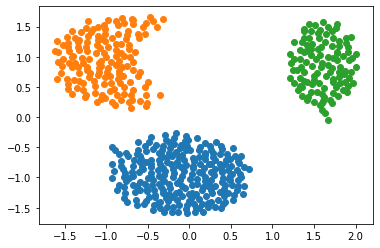

Silhouette score for k = 0.42105263157894735: 0.6931958759464847


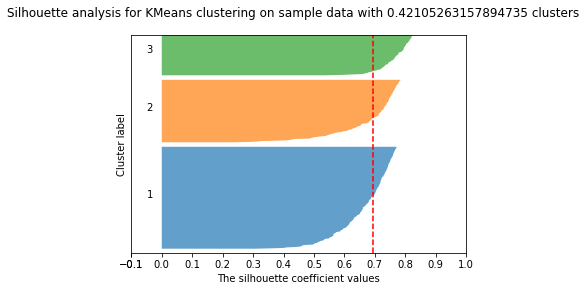

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.3684210526315789
There are 3 clusters and 0 outliers.


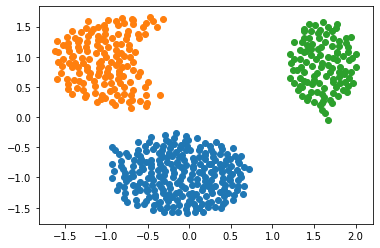

Silhouette score for k = 0.3684210526315789: 0.6931958759464847


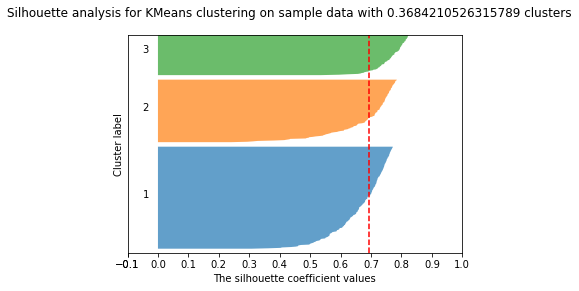

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.3157894736842105
There are 3 clusters and 2 outliers.


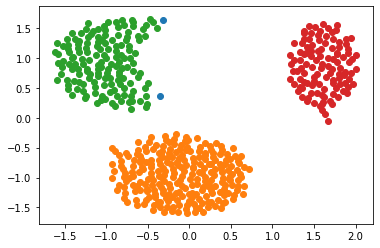

Silhouette score for k = 0.3157894736842105: 0.5696816131355236


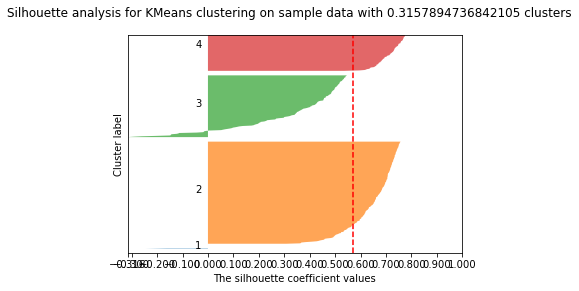

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.2631578947368421
There are 3 clusters and 7 outliers.


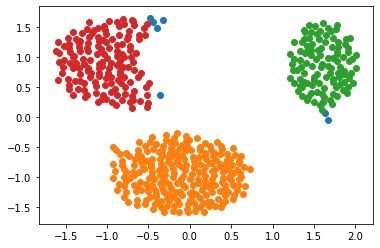

Silhouette score for k = 0.2631578947368421: 0.6302348624096256


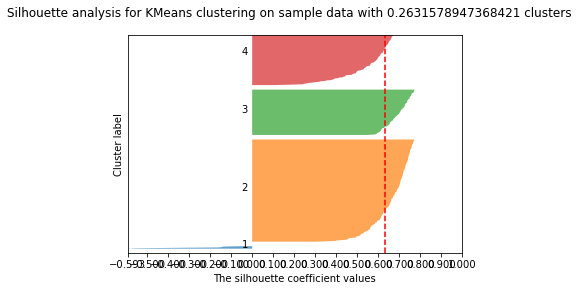

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.21052631578947367
There are 3 clusters and 246 outliers.


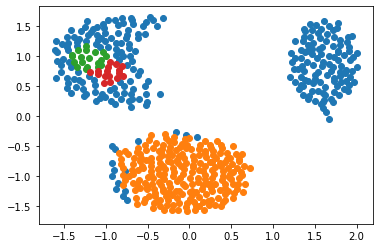

Silhouette score for k = 0.21052631578947367: 0.20748291040011008


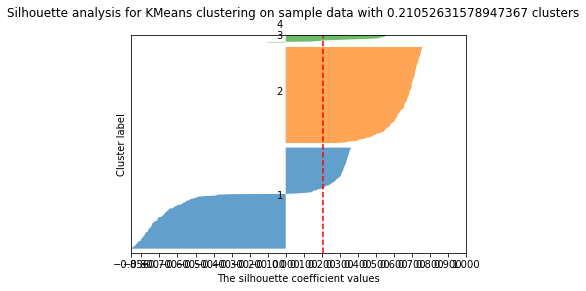

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.15789473684210525
There are 0 clusters and 515 outliers.


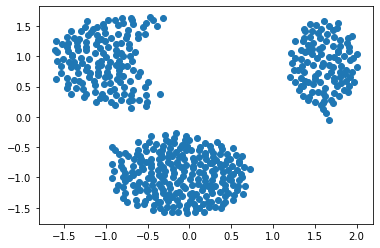

Silhouette score for k = 0.15789473684210525: nan


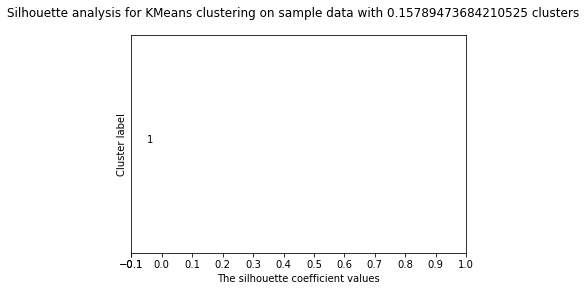

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.10526315789473684
There are 0 clusters and 515 outliers.


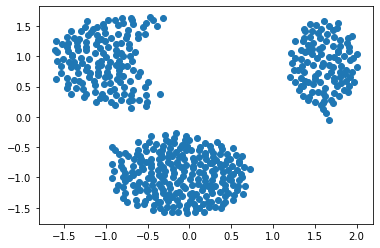

Silhouette score for k = 0.10526315789473684: nan


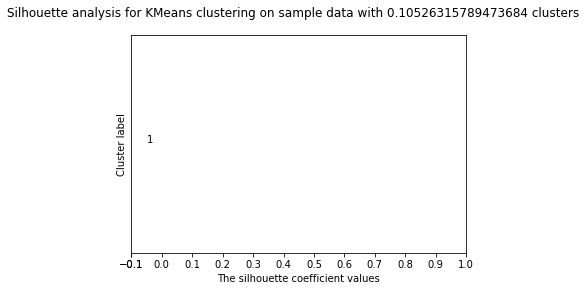

---------------------------------------------------------------------------------
Configuration: minDensity =  19 , eps =  0.05263157894736842
There are 0 clusters and 515 outliers.


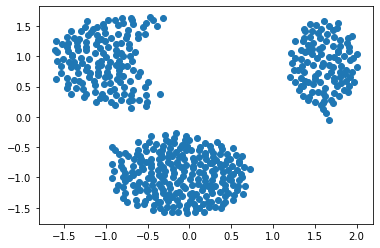

Silhouette score for k = 0.05263157894736842: nan


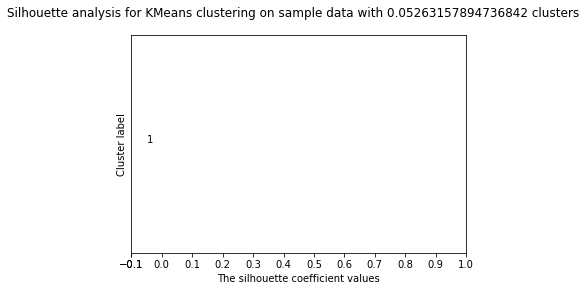

In [82]:
###############################
# Training step               #
###############################

DBSCAN_plot_multiple_parameters(training_set, 4, 20, 5, get_distance, 2, True)

**Conclusions:** the value of the minimum density did not seem to affect the results in a high significant way, for this dataset. For minimum distance, however, if eps is too large, we could have some clusters containing several distant sets with high density, that is, some clusters that could have been separated in more different clusters. On the other hand, if eps is too small, we can end up with too many outliers; in the example, when eps<=0.3, all points were classified as outliers, which is not befitting with reality.

### Setting the hiper-parameters as to validate the model

In [86]:
# set hiper-parameters with the appropiate values
best_eps = 0.35
best_density = 10 #2*dim

Based on the analysis of the elbow graph showed above, we chose the hiper-parameters to be:
minimum density =  10 and minimun distance =  0.35 

Now we will classify the test set. We use two approaches. In the fisrt one, we simply run the DBSCAN method over the test set using the configuration we found to be the most appropiate in the training step.
In the second approache, for each point of the test set, we find what its neighborhood would be in the training set, and then we count the number of times that each cluster occurs in this neighborhood. Finally, we assign the most frequent cluster in this neighborhood as the cluster of the point of the test set.
Observing the graphs ploted bellow, we can conclude that the second approach gave much better results than the first one.

### Validation step
> **First approach:** run DBSCAN for the test set with the most convenient configuration obtained from the training step.

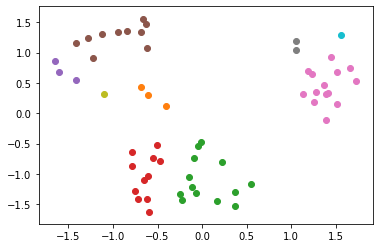

In [87]:
###############################
# Validation step             #
###############################

# first approach
#print("\n\033[1mFisrt approach:\033[0m run DBSCAN for the test set with the most convenient configuration obtained from the training step.")
model = []
clusters_1 = {}
testset_labeled, clusters_1 = DBSCAN(test_set, get_distance, 2, best_eps, best_density / len(test_set))
DBSCAN_plot_2D_clusters(clusters_1)


### Validation step
> **Second approach:** assign to each point in the test set, the \"most frequent cluster\" in the neighborhood of the point when considered the training set.

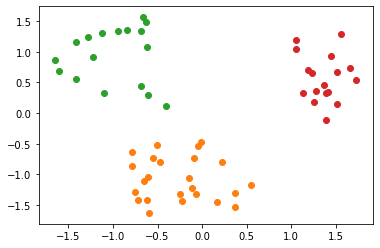

In [88]:
# second approach
#print("\n\033[1mSecond approach:\033[0m assign to each point in the test set, the \"most frequent cluster\" in the neighborhood of the point when considered the training set.")
# initialization of data set and auxiliary variables
v_set = DBSCAN_initialization(test_set)
neighbors_count = {key: 0 for key in range(0,50)}
v_clusters = {key: [] for key in range(0,50)}

# get model generated by training the training set
model, clusters_2 = DBSCAN(training_set, get_distance, 2, best_eps, best_density)  

# classify each point of the test set one of the clusters of the model
for v_point in v_set:
    # get neighborhood of the current point as if it was placed in the model set
    v_neighborhood = DBSCAN_find_neighborhood(model, get_distance, 2, best_eps, v_point)
    
    # count the number of neighbors of each cluster
    for q in v_neighborhood:
        neighbors_count[q.cluster] += 1
    
    # set current point to the "most frequent" cluster in its "model neighborhood"
    v_point.cluster = max(neighbors_count, key=neighbors_count.get)
    
    # reset the counter of neighbors of each cluster
    neighbors_count = {key: 0 for key in neighbors_count}
    
# construct the dictionary with all clusters and plot the result
for p in v_set:
    v_clusters[p.cluster].append(p)
DBSCAN_plot_2D_clusters(v_clusters)


### Final conclusions from the experiment of DBSCAN over a 2D dataset

blablabla


## Running DBSCAN for a n-dimensional dataset (n=10)

 
-------------------------------------------------------------------------------------
Elbow graph with k =  1



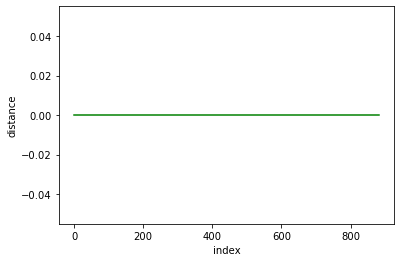

---------------------------------------------------------------------------------
Configuration: minDensity =  1 , eps =  1.0
There are 5 clusters and 0 outliers.
Silhouette score for k = 1.0: 0.5542329696240926


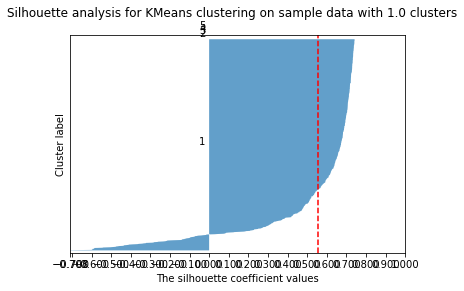

 
-------------------------------------------------------------------------------------
Elbow graph with k =  6



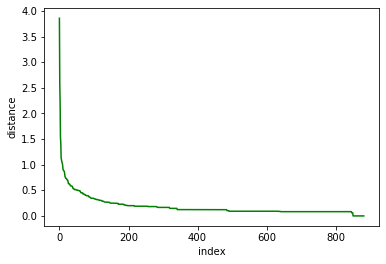

---------------------------------------------------------------------------------
Configuration: minDensity =  6 , eps =  1.0
There are 1 clusters and 5 outliers.
Silhouette score for k = 1.0: 0.6889082316887003


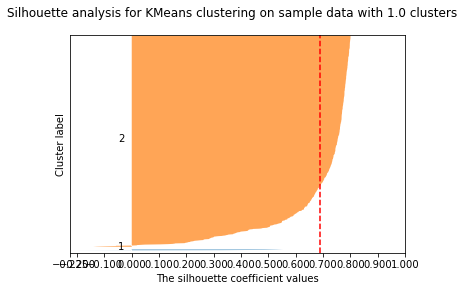

---------------------------------------------------------------------------------
Configuration: minDensity =  6 , eps =  0.8333333333333334
There are 1 clusters and 7 outliers.
Silhouette score for k = 0.8333333333333334: 0.6624092139924526


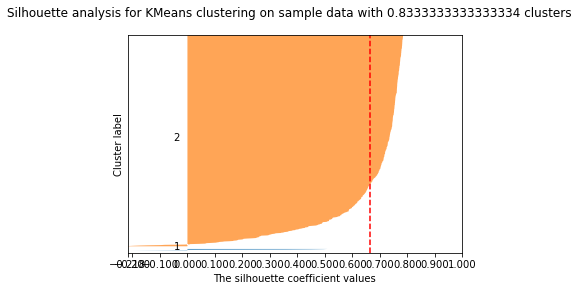

---------------------------------------------------------------------------------
Configuration: minDensity =  6 , eps =  0.6666666666666666
There are 1 clusters and 12 outliers.
Silhouette score for k = 0.6666666666666666: 0.6137758154042439


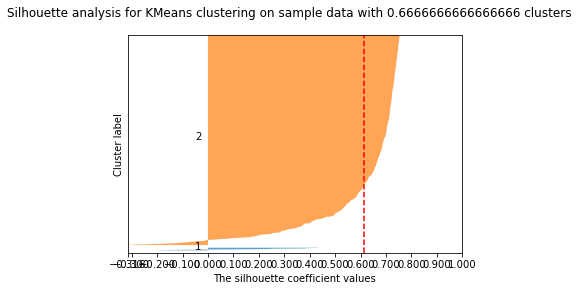

---------------------------------------------------------------------------------
Configuration: minDensity =  6 , eps =  0.5
There are 3 clusters and 30 outliers.
Silhouette score for k = 0.5: 0.4699236920467548


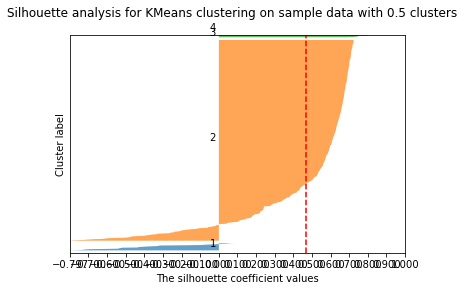

---------------------------------------------------------------------------------
Configuration: minDensity =  6 , eps =  0.3333333333333333
There are 4 clusters and 68 outliers.
Silhouette score for k = 0.3333333333333333: 0.3809324176782639


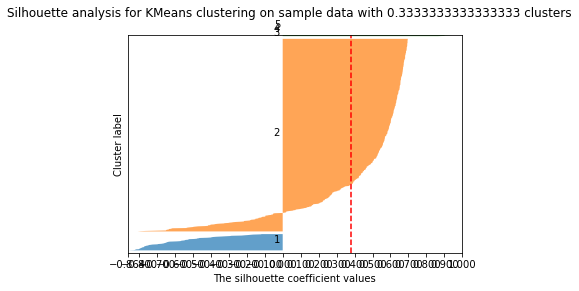

---------------------------------------------------------------------------------
Configuration: minDensity =  6 , eps =  0.16666666666666666
There are 4 clusters and 221 outliers.
Silhouette score for k = 0.16666666666666666: -0.029774168777619285


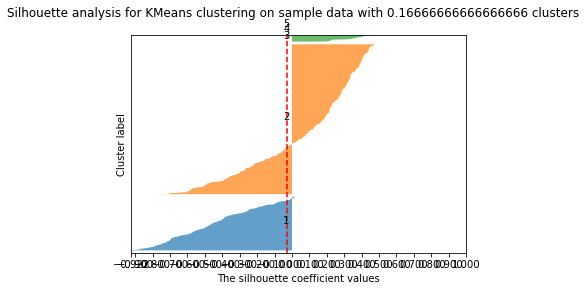

 
-------------------------------------------------------------------------------------
Elbow graph with k =  11



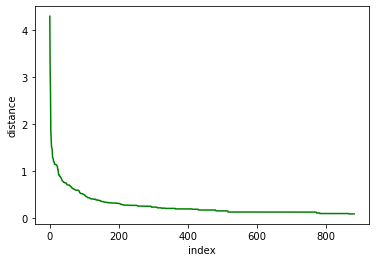

---------------------------------------------------------------------------------
Configuration: minDensity =  11 , eps =  1.0
There are 1 clusters and 5 outliers.
Silhouette score for k = 1.0: 0.6889082316887003


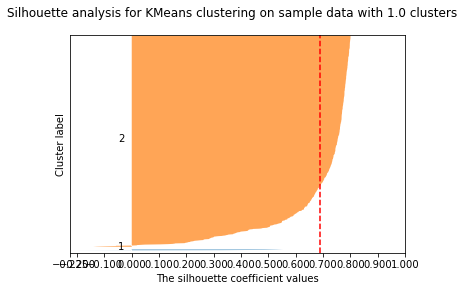

---------------------------------------------------------------------------------
Configuration: minDensity =  11 , eps =  0.9090909090909091
There are 1 clusters and 5 outliers.
Silhouette score for k = 0.9090909090909091: 0.6889082316887003


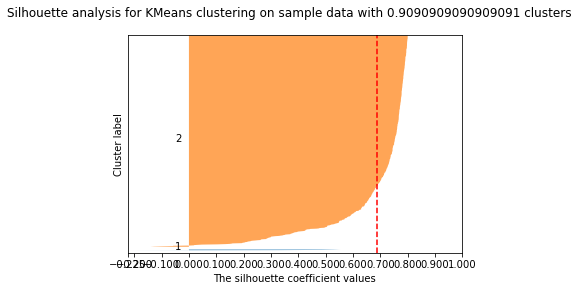

---------------------------------------------------------------------------------
Configuration: minDensity =  11 , eps =  0.8181818181818182
There are 1 clusters and 12 outliers.
Silhouette score for k = 0.8181818181818182: 0.6165686043214477


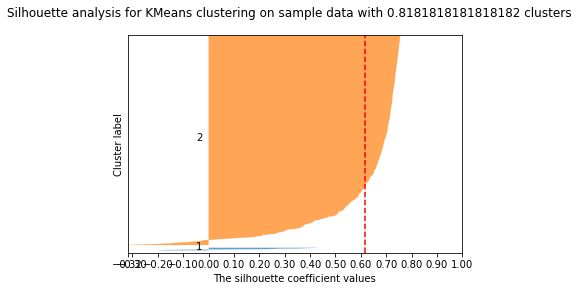

---------------------------------------------------------------------------------
Configuration: minDensity =  11 , eps =  0.7272727272727273
There are 1 clusters and 23 outliers.
Silhouette score for k = 0.7272727272727273: 0.5871544275484027


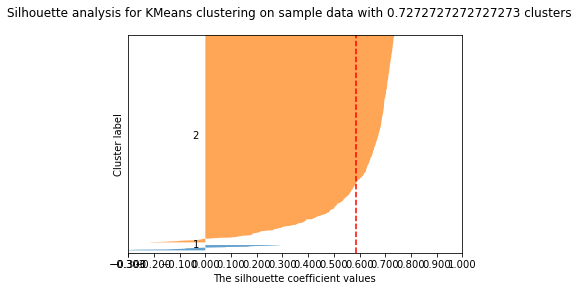

---------------------------------------------------------------------------------
Configuration: minDensity =  11 , eps =  0.6363636363636364
There are 2 clusters and 35 outliers.
Silhouette score for k = 0.6363636363636364: 0.502326743564749


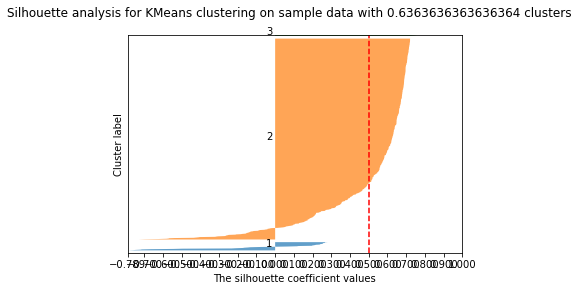

---------------------------------------------------------------------------------
Configuration: minDensity =  11 , eps =  0.5454545454545454
There are 1 clusters and 63 outliers.
Silhouette score for k = 0.5454545454545454: 0.5594203575433977


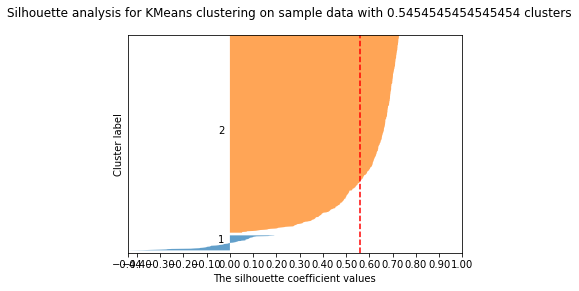

---------------------------------------------------------------------------------
Configuration: minDensity =  11 , eps =  0.45454545454545453
There are 1 clusters and 76 outliers.
Silhouette score for k = 0.45454545454545453: 0.5510426247192256


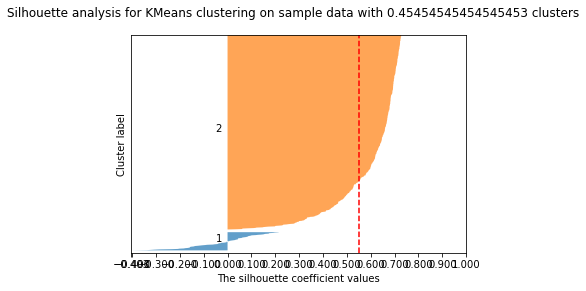

---------------------------------------------------------------------------------
Configuration: minDensity =  11 , eps =  0.36363636363636365
There are 1 clusters and 105 outliers.
Silhouette score for k = 0.36363636363636365: 0.5135413518661093


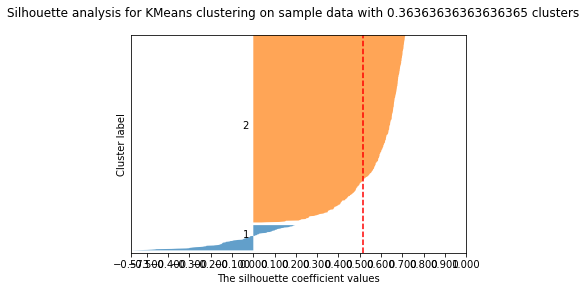

---------------------------------------------------------------------------------
Configuration: minDensity =  11 , eps =  0.2727272727272727
There are 1 clusters and 142 outliers.
Silhouette score for k = 0.2727272727272727: 0.46015352420322814


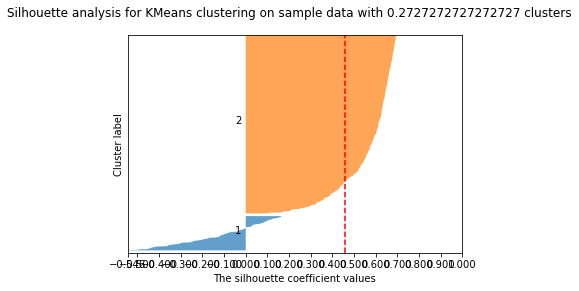

---------------------------------------------------------------------------------
Configuration: minDensity =  11 , eps =  0.18181818181818182
There are 3 clusters and 339 outliers.
Silhouette score for k = 0.18181818181818182: 0.11980531135374542


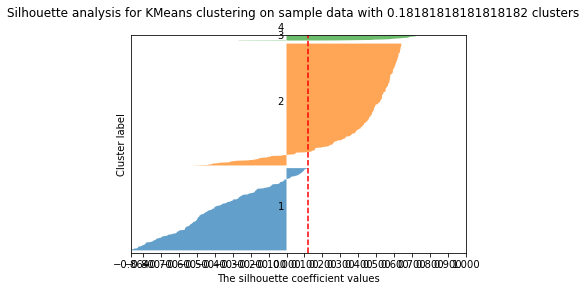

---------------------------------------------------------------------------------
Configuration: minDensity =  11 , eps =  0.09090909090909091
There are 3 clusters and 847 outliers.
Silhouette score for k = 0.09090909090909091: -0.36542084180048295


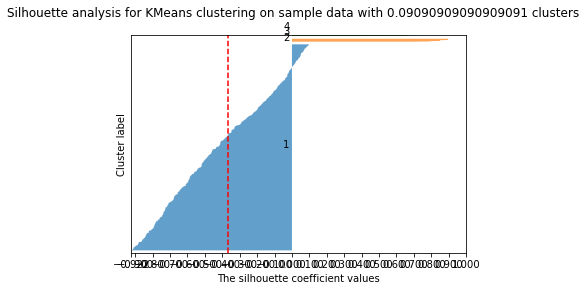

 
-------------------------------------------------------------------------------------
Elbow graph with k =  16



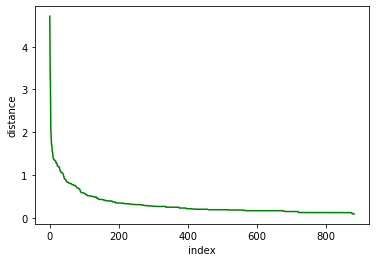

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  1.0
There are 1 clusters and 9 outliers.
Silhouette score for k = 1.0: 0.6558843171390989


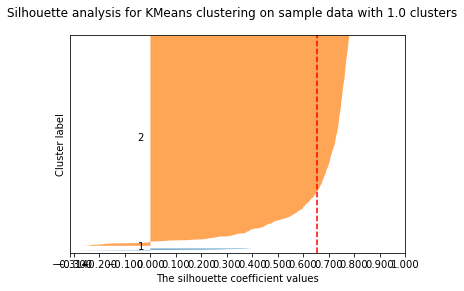

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.9375
There are 1 clusters and 11 outliers.
Silhouette score for k = 0.9375: 0.6301402218385381


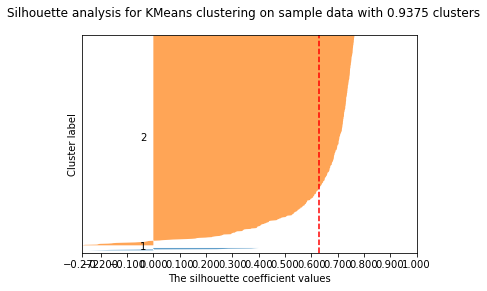

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.875
There are 1 clusters and 14 outliers.
Silhouette score for k = 0.875: 0.614477318247868


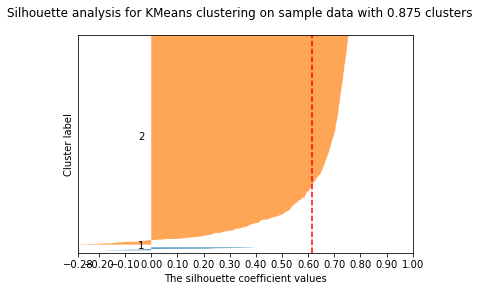

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.8125
There are 1 clusters and 22 outliers.
Silhouette score for k = 0.8125: 0.5949092713369784


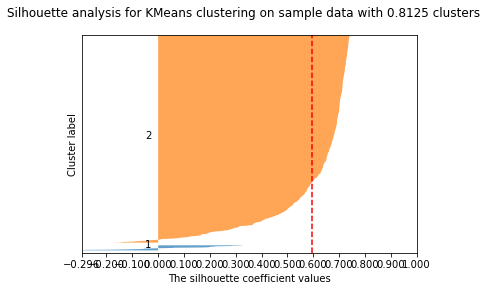

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.75
There are 1 clusters and 47 outliers.
Silhouette score for k = 0.75: 0.5782690861121172


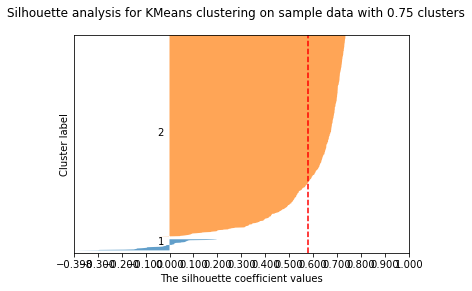

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.6875
There are 1 clusters and 57 outliers.
Silhouette score for k = 0.6875: 0.5650900925244339


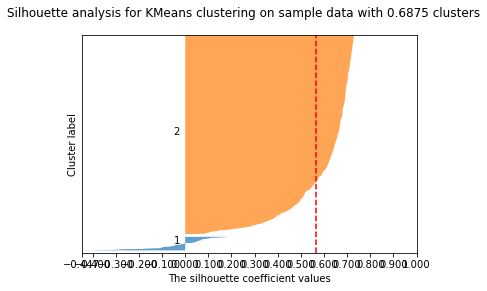

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.625
There are 1 clusters and 61 outliers.
Silhouette score for k = 0.625: 0.5650101410737469


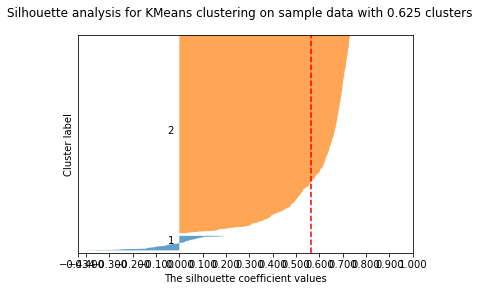

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.5625
There are 1 clusters and 70 outliers.
Silhouette score for k = 0.5625: 0.5555705517079759


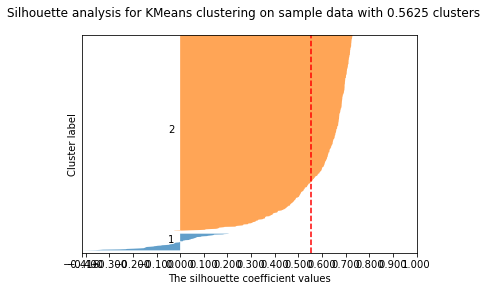

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.5
There are 1 clusters and 77 outliers.
Silhouette score for k = 0.5: 0.5516139510740715


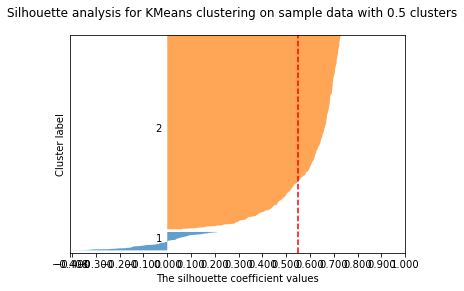

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.4375
There are 1 clusters and 87 outliers.
Silhouette score for k = 0.4375: 0.5368944670097513


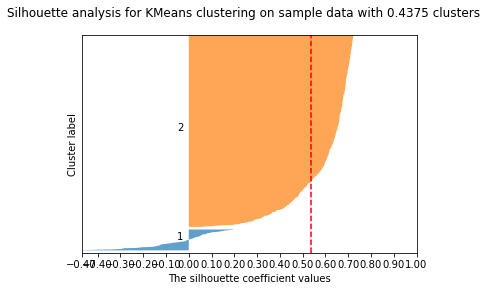

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.375
There are 1 clusters and 112 outliers.
Silhouette score for k = 0.375: 0.5032579062497233


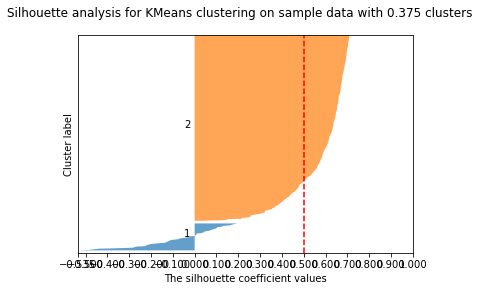

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.3125
There are 2 clusters and 148 outliers.
Silhouette score for k = 0.3125: 0.25263285484331666


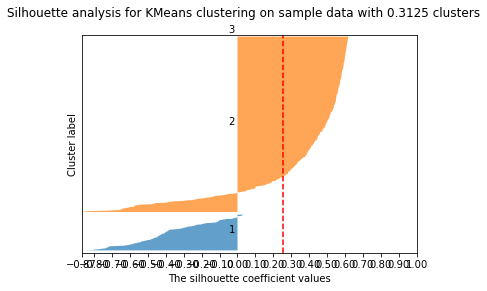

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.25
There are 1 clusters and 240 outliers.
Silhouette score for k = 0.25: 0.36730999188217595


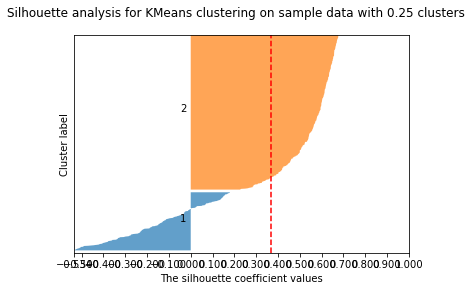

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.1875
There are 3 clusters and 371 outliers.
Silhouette score for k = 0.1875: 0.09953727820912811


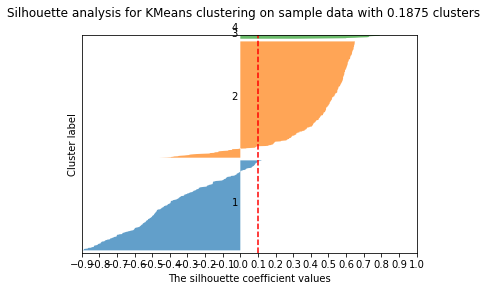

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.125
There are 5 clusters and 556 outliers.
Silhouette score for k = 0.125: -0.2764744404118565


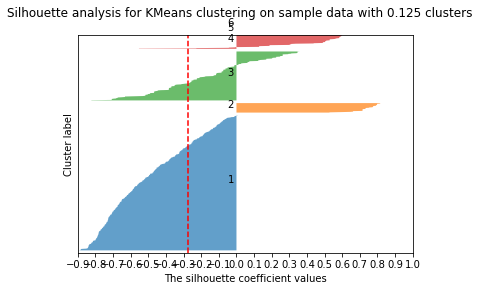

---------------------------------------------------------------------------------
Configuration: minDensity =  16 , eps =  0.0625
There are 0 clusters and 882 outliers.
Silhouette score for k = 0.0625: nan


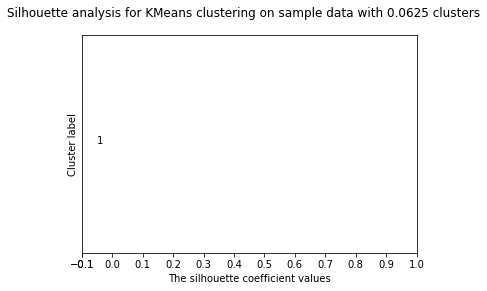

In [78]:
# Get dataset
ds_filepath = "trip_advisor.dat"
#ds_filepath = "wimbledon_men_2013.dat"
ds = get_dataset(ds_filepath)
dim = len(training_set[0].features) # get the number of features of the dataset

# Pre-process the dataset
random.seed(37154) 
random.shuffle(ds)
training_set, test_set = divide_dataset(ds, 0.9, 0.1) 
z_score_normalization(training_set, dim)
z_score_normalization(test_set, dim)

###############################
# Training step               #
###############################

DBSCAN_plot_multiple_parameters(training_set, 4, 20, 5, get_distance, dim, False)

In [74]:
###############################
# Validation step             #
###############################

# set hiper-parameters with the appropiate values
best_eps = 3.5
best_density = 2*dim

# first approach
print("\nFisrt approach: run DBSCAN for the test set with the most convenient configuration obtained from the training step.")

clusters_1 = {}
testset_labeled, clusters_1 = DBSCAN(test_set, get_distance, dim, best_eps, best_density / len(test_set))
# DBSCAN_plot_2D_clusters(clusters)
print("test set, approach 1, number of clusters: ", len(clusters_1))

# second approach
print("\nSecond approach: assign to each point in the test set, the \"most frequent cluster\" in the neighborhood of the point when considered the training set.")
# obtain the model by rinning DBSCAN over the training set with the best configuration of parameters
model = []
clusters = {}
model, clusters = DBSCAN(training_set, get_distance, dim, best_eps, best_density)
print("training set, number of clusters: ", len(clusters))

# initialization of data set and auxiliary variables
v_set = DBSCAN_initialization(test_set)
neighbors_count = {key: 0 for key in range(0,len(test_set))}
v_clusters = {key: [] for key in range(0,len(test_set))}

# run through each point of the test set so as to classify them
for v_point in v_set:
    # get neighborhood of the current point as if it was placed in the model set
    v_neighborhood = DBSCAN_find_neighborhood(model, get_distance, dim, best_eps, v_point)
    
    # count the number of neighbors of each cluster
    for q in v_neighborhood:
        neighbors_count[q.cluster] += 1
    
    # set current point to the "most frequent" cluster in its "model neighborhood"
    v_point.cluster = max(neighbors_count, key=neighbors_count.get)
    
    # reset the counter of neighbors of each cluster
    neighbors_count = {key: 0 for key in neighbors_count}
    
# construct the dictionary with all clusters and plot the result
for p in v_set:
    v_clusters[p.cluster].append(p)
    
print("teset set, number of clusters: ", len(v_clusters))


Fisrt approach: run DBSCAN for the test set with the most convenient configuration obtained from the training step.
test set, approach 1, number of clusters:  2

Second approach: assign to each point in the test set, the "most frequent cluster" in the neighborhood of the point when considered the training set.
training set, number of clusters:  2
teset set, number of clusters:  98


# Final remarks 

- dificulties
- division of work and research
- bla